In [2]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
columns = {0:'datetime',1:'open',2:'high',3:'low',4:'close',5:'volume'}

btc_raw = pd.read_csv("btcusd.csv", header=None)
eth_raw = pd.read_csv("ethusd60.csv", header=None)

In [4]:
def make_df(raw_df):
    df = raw_df.loc[:,:5]
    df.rename(columns=columns, inplace=True)
    df = df[["datetime", "close"]]
    
    df["timestamp"] = df["datetime"].apply(lambda x: dt.datetime.fromtimestamp(x))
    df = df.drop(columns="datetime")
    df.set_index("timestamp", inplace=True)
    df.index=pd.to_datetime(df.index)
    return df

In [5]:
btc = make_df(btc_raw)
eth = make_df(eth_raw)
btc.rename(columns={"close":"btc"}, inplace=True)
eth.rename(columns={"close":"eth"}, inplace=True)
hist_df = btc.merge(eth, how="inner", on="timestamp")
hist_df.index.dtype

dtype('<M8[ns]')

In [6]:
current_df = pd.read_csv("crypto_current.csv", parse_dates=True, infer_datetime_format=True, index_col="timestamp")
current_df.index.dtype

dtype('<M8[ns]')

In [7]:
num_ticks = 60
tickers = ["btc","eth"]
hist_shifted_df = pd.DataFrame()
for ticker in tickers:
    hist_shifted_df[ticker] = hist_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        hist_shifted_df[name] = hist_df[ticker].shift(i)
hist_shifted_df = hist_shifted_df.copy()
hist_shifted_df.shape

ipykernel_launcher:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


(45978, 120)

In [8]:
#This function performs a pct_change on the hourly price data over a 24 row period.  The data from kraken provides 24 hours of data for a 24-hour period, so this is the 24 hour return.
# It then shifts the pct_change back 24 rows so that the forward 24-hour return sits on the same timestamp as the current price.

hist_pct_returns_df_list = []
for ticker in tickers:
    name = f"{ticker}_24_Return"
    returns_df = pd.DataFrame()
    returns_df[name] = hist_df[ticker].pct_change(periods=24).shift(-24)
    hist_pct_returns_df_list.append(returns_df)
len(hist_pct_returns_df_list)

2

In [9]:
current_shifted_df = pd.DataFrame()
for ticker in tickers:
    current_shifted_df[ticker] = current_df[ticker].copy()
    for i in range(1,num_ticks):
        name = f"{ticker}-{i}"
        current_shifted_df[name] = current_df[ticker].shift(i)
current_shifted_df = current_shifted_df.copy()
current_shifted_df.dropna(inplace=True)

ipykernel_launcher:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [10]:
hist_pctchange_df = hist_shifted_df.pct_change()
hist_pctchange_df = pd.concat([hist_pctchange_df, *hist_pct_returns_df_list], axis=1)
hist_pctchange_df.dropna(inplace=True)
hist_pctchange_df.shape

(45894, 122)

In [11]:
current_pctchange_df = current_shifted_df.pct_change()
current_pctchange_df.dropna(inplace=True)

In [12]:
y_start = len(tickers)*num_ticks

In [13]:
from sklearn.linear_model import LinearRegression
X = hist_pctchange_df.iloc[:,0:y_start].values
y = []
for i in range(0,len(tickers)):
    y.append(hist_pctchange_df.iloc[:,y_start+i].values)
lin_models = []
y_lin_predicted = []

In [14]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = LinearRegression()
    model.fit(X,y[i])
    lin_models.append(model)
    predicted = model.predict(X)
    y_lin_predicted.append(predicted)

In [15]:
from sklearn.metrics import r2_score
import numpy as np
r2 = [0]*len(tickers)
for i in range(0,len(tickers)):
    r2[i] = r2_score(y[i], y_lin_predicted[i])
    print(f"The r2 score for symbol {tickers[i]} is {r2[i]}")

The r2 score for symbol btc is 0.0037583232960800572
The r2 score for symbol eth is 0.007746504583232894


In [20]:
#Predict pct-change for each of the tickers over the month of June 2021
y_current_predicted = []
current_returns_df_list = []
X = current_pctchange_df.values
for i in range(0,len(tickers)):
    ticker = tickers[i]
    model = lin_models[i]
    predicted = model.predict(X)
    y_current_predicted.append(predicted)
    return_df = pd.DataFrame({"timestamp":current_pctchange_df.index, "prediction": predicted})
    return_df["buy"] = return_df['prediction'].apply(lambda x: 1 if x >= 0.01 else 0)
    return_df = return_df.set_index("timestamp")
    return_df = return_df.merge(current_df[ticker], how="left", on="timestamp")

    money = 10000
    num_shares = 0
    state = 0
    buy_index = 0
    money_list=[]

    for i in range(0,len(return_df)):
        if state == 1 and i == buy_index + 16:
            #sell
            price = return_df.iloc[i,2]
            money = num_shares * price
            state = 0
            print(f"sell {ticker}", i ,price)

        if return_df.iloc[i,1] == 1 and state == 0 and i < len(return_df) - 16:
            #buy
            price = return_df.iloc[i,2]
            num_shares = money / price
            buy_index = i
            state = 1
            print(f"buy {ticker}", i, price)

        if return_df.iloc[i,1] == 1 and state == 1 and i < len(return_df) - 16:
            buy_index = i

        if state == 0 :
            money_list.append(money)
        else:
            price = return_df.iloc[i,2]
            money_list.append(num_shares*price)
    
    return_df["ROI"] = money_list

    current_returns_df_list.append(return_df)

buy btc 101 32193.4
sell btc 117 34031.9
buy btc 417 31511.5
sell btc 439 32429.8
buy btc 450 33920.1
sell btc 466 33485.7
buy eth 11 2692.49
sell eth 27 2652.71
buy eth 86 2483.85
sell eth 113 2476.5
buy eth 151 2460.0
sell eth 188 2309.11
buy eth 193 2435.76
sell eth 216 2359.48
buy eth 248 2541.43
sell eth 273 2532.01
buy eth 333 2302.11
sell eth 349 2252.41
buy eth 357 2228.05
sell eth 374 2179.74
buy eth 398 2189.83
sell eth 441 1875.01
buy eth 469 1908.46
sell eth 495 1999.51
buy eth 506 1824.17
sell eth 540 1836.11
buy eth 568 1972.79
sell eth 612 2173.47
buy eth 615 2125.05
sell eth 654 2114.32


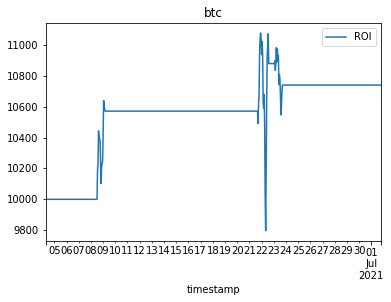

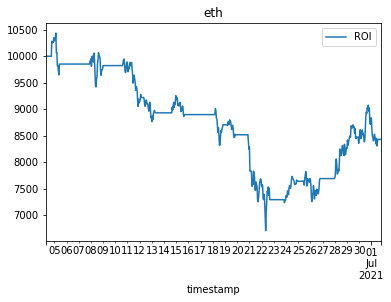

In [21]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    current_returns_df_list[i].plot(y="ROI", title=ticker)

In [22]:
starting_amount = 10000*len(tickers)
ending_amount = 0
for i in range(0,len(tickers)):
    ending_amount += current_returns_df_list[i].iloc[-1,-1]
ending_amount

19170.635000391918

In [24]:
summary_df = current_returns_df_list[0].copy()
summary_df = pd.DataFrame(summary_df["ROI"])
summary_df = summary_df.rename(columns={"ROI": f"LIN_{tickers[0]}"})
for i in range(1,len(tickers)):
    temp_df = current_returns_df_list[i].copy()
    temp_df = pd.DataFrame(temp_df["ROI"])
    temp_df = temp_df.rename(columns={"ROI": f"LIN_{tickers[i]}"})
    summary_df = pd.concat([summary_df, temp_df], axis=1)
summary_df.to_csv("crypto_lin_roi.csv")